In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

## Import the data
 First we load all the datasets that we will be using.

In [2]:
# Data paths (folder and path are seperated in order to easily check if the pickle version of the file exists)
characters_metadata_path    = {'path':'./data/MovieSummaries/character.metadata',   'extension':'.tsv'}
movies_metadata_path        = {'path':'./data/MovieSummaries/movie.metadata',       'extension':'.tsv'}
movie_summaries_path        = {'path':'./data/MovieSummaries/plot_summaries',       'extension':'.txt'}

imdb_names_path         = {'path':'./data/imdb/imdb_names',         'extension':'.tsv'} 
imdb_principals_path    = {'path':'./data/imdb/imdb_principals',    'extension':'.tsv'}
imdb_ratings_path       = {'path':'./data/imdb/imdb_ratings',       'extension':'.tsv'} 
imdb_titles_path        = {'path':'./data/imdb/imdb_titles',        'extension':'.tsv'}

kaggle_awards_path = {'path':'./data/kaggle/the_oscar_award', 'extension':'.csv'}

# Column names for the MCU datasets (since they are not provided in the datasets themselves)
colnames_charac = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID']
colnames_movie = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'] 
colnames_plot = ['Wikipedia movie ID', 'Plot'] 

For efficiency, we use pickle in order to speed up the loading process.

In [3]:
pkl_extension = ".pkl"

# Load the dataset given the data dict containing the path and the file extension and check if 
# the pickle exists and either load it or create it and return the dataframe
def load_and_pickle(data_dict, default_load):
    if os.path.exists(data_dict['path'] + pkl_extension):
        print('Pickle file found for {} .'.format(data_dict['path']))
        return pd.read_pickle(data_dict['path'] + pkl_extension)
    else:
        print('No pickle found for {}. Creating it...'.format(data_dict['path']))
        df = default_load(''.join(data_dict.values()))
        df.to_pickle(data_dict['path'] + pkl_extension)
        return df

In [4]:
# N.B takes ~2 minute without pickles, ~20 seconds with pickles

# Load datasets 
meta_charac_raw = load_and_pickle(characters_metadata_path, lambda path: pd.read_csv(path, names=colnames_charac, sep='\t'))
meta_movie_raw  = load_and_pickle(movies_metadata_path, lambda path: pd.read_csv(path, names=colnames_movie, sep='\t'))
plot            = load_and_pickle(movie_summaries_path, lambda path: pd.read_csv(path, names=colnames_plot, sep='\t'))

# Load IMDb datasets
imdb_names      = load_and_pickle(imdb_names_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_principals = load_and_pickle(imdb_principals_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_raitings   = load_and_pickle(imdb_ratings_path, lambda path: pd.read_csv(path, header=0 , sep='\t'))
imdb_title_raw  = load_and_pickle(imdb_titles_path, lambda path: pd.read_csv(path, header=0, sep='\t', dtype= 'string'))

# Load kaggle awards dataset
kaggle_awards_raw = load_and_pickle(kaggle_awards_path, lambda path: pd.read_csv(path, header=0))

Pickle file found for ./data/MovieSummaries/character.metadata .
Pickle file found for ./data/MovieSummaries/movie.metadata .
Pickle file found for ./data/MovieSummaries/plot_summaries .
No pickle found for ./data/imdb/imdb_names. Creating it...
Pickle file found for ./data/imdb/imdb_principals .
Pickle file found for ./data/imdb/imdb_ratings .
Pickle file found for ./data/imdb/imdb_titles .
Pickle file found for ./data/kaggle/the_oscar_award .


## Shaping the datasets

Here the goal is simply to make sure that the columns in datasets have correct types and to remove columns that we won't be needing so as not to clutter our analysis

In [5]:
# Select columns of the original dataset
meta_charac = meta_charac_raw.drop(['Freebase movie ID', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID'], axis=1).copy()
meta_movie = meta_movie_raw.drop(['Freebase movie ID', 'Movie languages', 'Movie countries'], axis=1).copy()

# Select colomns of IMDb datasets
imdb_title = imdb_title_raw.drop(['endYear', 'runtimeMinutes'], axis=1).copy()

# Select columns of kaggle awards dataset
kaggle_awards = kaggle_awards_raw.drop(['category'], axis = 1).copy()

In [6]:
# For consistency we remove day and month from actor date of birth and movie release date.
meta_movie["Movie release date"] = meta_movie["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Movie release date"] = meta_charac["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Actor date of birth"] = meta_charac["Actor date of birth"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())

# Turn movie genres into dictionary
meta_movie['Movie genres'] = meta_movie['Movie genres'].apply(ast.literal_eval)

In [7]:
print('--- Meta Movie ---')
print(meta_movie.dtypes.to_string())
print('--- Meta Character ---')
print(meta_charac.dtypes.to_string())
print('--- Plot ---')
print(plot.dtypes.to_string())

--- Meta Movie ---
Wikipedia movie ID            int64
Movie name                   object
Movie release date            Int64
Movie box office revenue    float64
Movie runtime               float64
Movie genres                 object
--- Meta Character ---
Wikipedia movie ID       int64
Movie release date       Int64
Character name          object
Actor date of birth      Int64
Actor gender            object
Actor height           float64
Actor ethnicity         object
Actor name              object
Actor age              float64
--- Plot ---
Wikipedia movie ID     int64
Plot                  object


We will now have a look at the NaNs in the resulting datasets

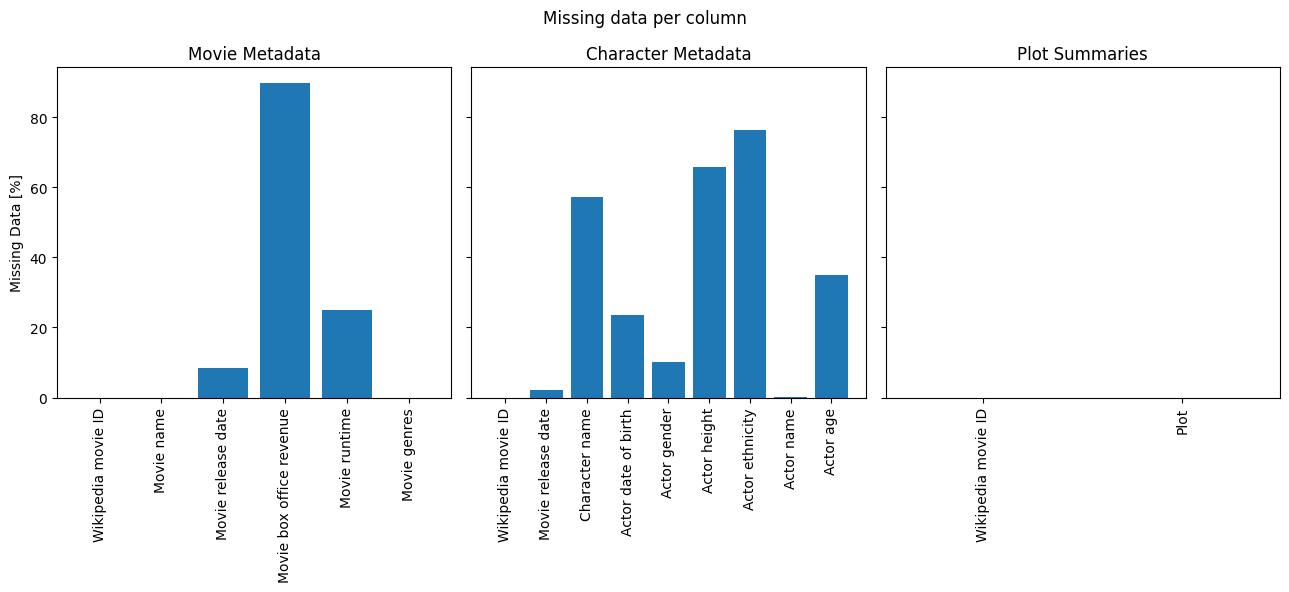

--- Dataset shapes ---
Movies metadata: (81741, 6)
Character metadata: (81741, 6)
Plot summaries: (42303, 2)


In [8]:
# Calculating missing data
missing_movie = meta_movie.isnull().sum() * 100 / len(meta_movie)
missing_char = meta_charac.isnull().sum() * 100 / len(meta_charac)
missing_plot = plot.isnull().sum() * 100 / len(plot)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6), sharey=True)
fig.suptitle('Missing data per column')

# Set axis labels and titles
ax1.set(ylabel= 'Missing Data [%]')
ax1.bar(missing_movie.index, missing_movie.values)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.set_title("Movie Metadata")
ax2.bar(missing_char.index, missing_char.values)
ax2.tick_params(axis='x', labelrotation = 90)
ax2.set_title("Character Metadata")
ax3.bar(missing_plot.index, missing_plot.values)
ax3.tick_params(axis='x', labelrotation = 90)
ax3.set_title("Plot Summaries")
plt.tight_layout()
plt.show()

print("--- Dataset shapes ---")
print("Movies metadata: {}" .format(meta_movie.shape))
print("Character metadata: {}" .format(meta_movie.shape))
print("Plot summaries: {}" .format(plot.shape))

*Observation:* From this initial analysis, it's evident that there is a significant amount of missing data.

*Action:* To address this, we've decided to drop certain actor features, specifically `character name` ,  `actor height`, `actor ethnicity`, and `actor age`, recognizing the high incidence of missing values in these columns. We are keeping `Movie box office revenue` but acknowledge the presence of missing values, and we plan to incorporate it into our analysis only if we have the resources and time to enrich our database.


In [9]:
charac = meta_charac.drop(columns=['Character name','Actor ethnicity', 'Actor height', 'Actor age'])

# 1. Dataframe 1: movies
## 1.1 Adding IMDb scores
We will start by adding the IMDb scores to the movie dataset, we want every movie in our dataset to have a rating, so we will use an **inner merge** (default) on the **title** and **year**. 

But first will need to have a look at the IMDb dataset.

In [10]:
# Display a sample of 5 rows from the 'imdb_title' DataFrame.
print("     ----- Title data sample -----")
display(imdb_title.sample(5))

# Display a sample of 5 rows from the 'imdb_ratings' DataFrame.
print("     ----- Raiting data overview -----")
display(imdb_raitings.sample(5))

     ----- Title data sample -----


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres
6757102,tt28143224,tvEpisode,Résumé quotidien,Résumé quotidien,0,2001,"Game-Show,Reality-TV,Romance"
2812472,tt1337093,short,B-Hurst,B-Hurst,0,2009,"Drama,Short"
8199343,tt5245656,tvEpisode,Episode #1.88,Episode #1.88,0,2015,"Comedy,Romance"
3694295,tt14996282,tvEpisode,Episode #1.51,Episode #1.51,0,\N,"Adventure,Fantasy"
8176606,tt5194118,tvEpisode,Selling the Row House and Moving to the Philly...,Selling the Row House and Moving to the Philly...,0,2015,Reality-TV


     ----- Raiting data overview -----


,tconst,averageRating,numVotes
660752,tt1399610,8.1,15
879780,tt2162776,7.3,219
160303,tt0262236,7.9,20
196267,tt0337602,7.0,5
554277,tt1183384,6.5,14


In [11]:
# keep only movies
imdb_movieTitle = imdb_title[imdb_title['titleType'] == 'movie'].copy() 
# remove Nan years
imdb_movieTitle = imdb_movieTitle[imdb_movieTitle['startYear'] != '\\N'].copy() 
# turn year to int
imdb_movieTitle['startYear'] = imdb_movieTitle['startYear'].astype(int) 
# rename actor ID for ease of use
imdb_names.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True) 

# Merging the IMDb and CMU datasets
movies = meta_movie\
            .merge(imdb_movieTitle[['originalTitle','startYear','tconst']], left_on= ['Movie name', 'Movie release date'], right_on= ['originalTitle','startYear'], how= 'inner')\
            .merge(imdb_raitings, how ='inner')
movies.rename(columns={"tconst":"IMDb_ID"}, inplace= True) #rename IMDb ID for ease of use

print("--- Movie dataset size ---")
print(movies.shape)

--- Movie dataset size ---
(35612, 11)


The merge will only consider movies whose titles are an exact match which might not always be the case due to different capitalization of different coma placement. Thus the 35'000 rows that we get is a lower bound of the amount of rows that we could get if we used a more clever matching technique. For instance we could mitigate the problem of capitals matching by putting all strings to lower case.

## 1.2 Filtering
We are proceeding to filter outliers in the dataset. The goal is to identify and exclude any data points that deviate significantly from the general pattern, ensuring that our analysis is not influenced by extreme values.

In [12]:
# Save an unfieltered version of movies
movies_uf = movies.copy()

# We are removing outliers in the film duration to standardize our data
max_movie_runtime = 200 # [minutes]
min_movie_runtime = 40  # [minutes]
movies = movies.query('`Movie runtime` <= @max_movie_runtime and `Movie runtime` >= @min_movie_runtime').copy()

# To ensure enough films are available per year, we are removing the older and newer years
max_movie_year = 2012
min_movie_year = 1930
movies = movies.query('`Movie release date` <= @max_movie_year and `Movie release date` >= @min_movie_year').copy()


In [41]:
# Display a random sample of 5 rows from the 'movies' DataFrame.
movies.sample(5)

,Wikipedia movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie genres,originalTitle,startYear,IMDb_ID,averageRating,numVotes
28587,10541514,High Heels and Low Lifes,2001,228194.0,85.0,"{'/m/0hj3m_x': 'Crime Comedy', '/m/03btsm8': '...",High Heels and Low Lifes,2001,tt0253126,6.1,3663
3524,2853895,The Pirate,1948,NaN,101.0,"{'/m/02qvnvs': 'Swashbuckler films', '/m/04t36...",The Pirate,1948,tt0040694,6.9,5435
31806,4348820,Down and Derby,2005,NaN,94.0,"{'/m/01z02hx': 'Sports', '/m/0hqxf': 'Family F...",Down and Derby,2005,tt0398971,5.5,699
4926,10940395,Unknown World,1951,NaN,64.0,"{'/m/01drsx': 'Disaster', '/m/06n90': 'Science...",Unknown World,1951,tt0044167,4.1,1261
8493,2861237,Last Dance,1996,5939449.0,103.0,"{'/m/01jfsb': 'Thriller', '/m/0lsxr': 'Crime F...",Last Dance,1996,tt0116827,5.7,4648


# 2. Dataframe 2 : Actors
## 2.1 Extracting main characters from IMDb 


In [13]:
# Input: 
#   - movies: DataFrame containing movie dataset 
#   - imdb_principals: IMDb dataset with principal actors
#   - top_n: Number of principal actors to extract (default 3) [int]
# Output: 
#   - movie_actors: DataFrame with all actors per film. Columns: IMDb_ID, actor, ordering (corresponds to the significance of actors in films)
def get_top_actors(movies, imdb_principals, top_n=3):
    # Filter the 'imdb_principals' DataFrame to include only rows where the category is 'actor' or 'actress'.
    imdb_principal_actors = imdb_principals.query('category == "actor" | category == "actress"')

    # Further filter the above DataFrame to include only those actors/actresses that appear in the 'movies' DataFrame (matched by 'IMDb_ID')
    # and are within the top 'top_n' ordering. 'ordering' likely refers to the importance or lead level of the actor in the movie.
    imdb_principal_actors_valid = imdb_principal_actors[(imdb_principal_actors["IMDb_ID"].isin(movies["IMDb_ID"].values.tolist())) & 
                                                        (imdb_principal_actors["ordering"] <= top_n)]

    # Initialize an empty list to store movie-actor pairings.
    movie_actors = []

    bar = progressbar.ProgressBar(maxval=len(movies["IMDb_ID"])).start()

    # Iterate over each movie ID in the 'movies' DataFrame.
    for idx, id in enumerate(movies["IMDb_ID"]):
         # For each movie, find corresponding actors from 'imdb_principal_actors_valid' and select 'ordering' and 'IMDb_actor_ID'.
        tmp = imdb_principal_actors_valid.loc[imdb_principal_actors_valid["IMDb_ID"] == id][["ordering", "IMDb_actor_ID"]]

        # Append each actor's information along with the movie ID to the 'movie_actors' list.
        for _, row in tmp.iterrows():
            movie_actors.append([id, row["IMDb_actor_ID"], row["ordering"]])
        bar.update(idx)

    # Convert the 'movie_actors' list into a DataFrame for easier handling and readability.
    movie_actors = pd.DataFrame(movie_actors, columns=['IMDb_ID', 'IMDb_actor_ID', 'ordering'])

    # Return the resulting DataFrame.
    return movie_actors

In [14]:
# takes ~5 mins to run
imdb_principals.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True)
imdb_principals.rename(columns={'tconst':'IMDb_ID'}, inplace=True)

movie_actors = get_top_actors(movies, imdb_principals)
movie_actors.sample(5)

,IMDb_ID,IMDb_actor_ID,ordering
49903,tt0029808,nm0533692,3
31231,tt0062345,nm0450138,3
35450,tt0049476,nm0132930,1
78249,tt0294806,nm1310505,2
59475,tt0024549,nm0949835,1


## 2.2 Creating a one-to-many relationship
We want a one-to-many relationship between movies and movie_actors, i.e for every movie_actor, there is **exactly** one corresponding movie (no NaNs).

In [15]:
# creation of the DataFrame only with valid actors
movies = movies[movies["IMDb_ID"].isin(movie_actors["IMDb_ID"].unique().tolist())]

## 2.3 Adding information to the dataset
We will now added additional data to the actors dataset

In [16]:
# takes ~10 seconds
# Merge 'movie_actors' with selected columns from 'movies' and 'imdb_names' DataFrames.
actors = movie_actors.merge(movies[['Wikipedia movie ID', 'Movie name', 'Movie release date', 'IMDb_ID']], on='IMDb_ID')
actors = actors.merge(imdb_names[['primaryName', 'IMDb_actor_ID']], left_on='IMDb_actor_ID', right_on='IMDb_actor_ID')

# Display a sample of 5 rows from the resulting 'actors' DataFrame.
actors.sample(5)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName
16571,tt1078912,nm0005562,2,18764957,Night at the Museum: Battle of the Smithsonian,2009,Owen Wilson
877,tt0048087,nm0001289,1,14594030,Footsteps in the Fog,1955,Stewart Granger
4429,tt0076054,nm0000149,2,7533357,Freaky Friday,1976,Jodie Foster
77353,tt0431077,nm0620090,2,4841276,G@me,2003,Yukie Nakama
72397,tt0223699,nm0747808,2,36129686,Margaret Atwood: Once in August,1984,Michael Rubbo


## 2.4 Adding awards feature

As a specific actor feature, we want to use the number of awards won. To do this we use a kaggle dataset ([link](https://www.kaggle.com/datasets/unanimad/the-oscar-award/code)).


In [17]:
print("kaggle awards shape: " + str(kaggle_awards.shape))
kaggle_awards.sample(5)

kaggle awards shape: (10765, 6)


,year_film,year_ceremony,ceremony,name,film,winner
1150,1941,1942,14,Philadelphia Housing Association,A Place to Live,False
5809,1979,1980,52,"Harry Mathias, Jay Zukerman and Larry Hankin, ...",Solly's Diner,False
9719,2014,2015,87,"Tim Bevan, Eric Fellner, Lisa Bruce and Anthon...",The Theory of Everything,False
4689,1969,1970,42,"Art Direction: Robert Boyle, George B. Chan; ...","Gaily, Gaily",False
7775,1997,1998,70,"Hilary Henkin, David Mamet",Wag the Dog,False


We should filter to keep only movies that are in our dataset

In [18]:
# Keep only actors that are in our actors DataFrame
kaggle_awards = kaggle_awards[kaggle_awards['name'].isin(actors['primaryName'].unique())]
# Keep only movies that are in our movies DataFrame
kaggle_awards = kaggle_awards[kaggle_awards['film'].isin(movies['Movie name'].unique())]
kaggle_awards.sample(5)

,year_film,year_ceremony,ceremony,name,film,winner
2180,1948,1949,21,Clifton Webb,Sitting Pretty,False
5524,1977,1978,50,Leslie Browne,The Turning Point,False
7110,1992,1993,65,Gene Hackman,Unforgiven,True
8011,2000,2001,73,Geoffrey Rush,Quills,False
1810,1945,1946,18,Gregory Peck,The Keys of the Kingdom,False


Let's have a quick scan of the amount of NaNs in this new dataset

In [33]:
kaggle_nans = kaggle_awards.isnull().sum() * 100 / len(kaggle_awards)
display(kaggle_nans)

year_film        0.0
year_ceremony    0.0
ceremony         0.0
name             0.0
film             0.0
winner           0.0
dtype: float64

As we can see, the dataset is NaNs free.

Let's now define a function to get the number of awards won by a given actor up until a given year. For this feature we will only consider the number of awards that the actor won before the movie was released. Using this function we will be able to add a new column in our previous dataframe. 

The function allow counting both the amount of awards won but also the number of nominations

In [48]:
# Input: 
#   - actor_name (str)
#   - year (int)
#   - won (bool) -> Was the nomination won 
# Output:
#   - Number of awards/nominations gained by the actor
def count_awards(actor_name, year, won):
    # We check with the ceremony year because the actor hasn't recieved an award until the ceremony has happened
    if won:
        filtered = kaggle_awards.query("year_ceremony <= @year & name == @actor_name & winner==True")
    else:
        filtered = kaggle_awards.query("year_ceremony <= @year & name == @actor_name")
    
    return len(filtered)

In [49]:
# Takes ~5 mins
# Add 'awards' and 'nominations' columns to the 'actors' DataFrame, calculated using the 'count_awards' function.
actors['awards'] = [count_awards(row['primaryName'], row['Movie release date'], True) for (index, row) in actors.iterrows()]
actors['nominations'] = [count_awards(row['primaryName'], row['Movie release date'], False) for (index, row) in actors.iterrows()]

Let's take a look at Meryl Streep's films as an example to showcase what this function has done

In [50]:
actors.query("primaryName == 'Meryl Streep'").sort_values('Movie release date').head(5)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,awards,nominations
6766,tt0079417,nm0000658,2,103026,Kramer vs. Kramer,1979,Meryl Streep,0,1
6791,tt0079875,nm0000658,3,9090163,The Seduction of Joe Tynan,1979,Meryl Streep,0,1
6767,tt0082416,nm0000658,1,3602324,The French Lieutenant's Woman,1981,Meryl Streep,1,2
6793,tt0084707,nm0000658,1,4016437,Sophie's Choice,1982,Meryl Streep,1,3
6774,tt0084732,nm0000658,2,11612605,Still of the Night,1982,Meryl Streep,1,3


# 3 Final Data Analysis 
Let's take a look at what our final DataFrames look like
## 3.1 Dataframe 1: Movies

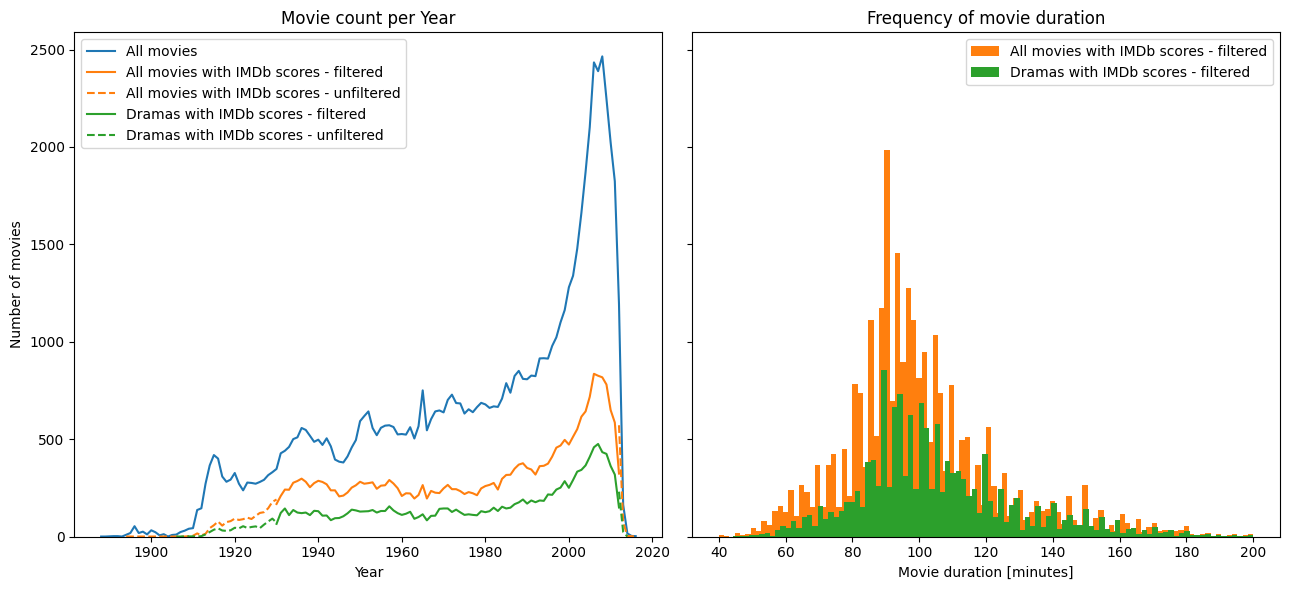

In [51]:
# Get unfiltered movies with IMDb scores -> Selecting years that will not be plotted with the filtered data
movies_ufR = movies_uf.query('`Movie release date` >= @max_movie_year').copy()
movies_ufL = movies_uf.query('`Movie release date` <= @min_movie_year').copy()

# Get filtered and unfiltered drama movies
drama_movies = movies[movies['Movie genres'].apply(lambda x: 'Drama' in x.values())]
drama_movies_ufR = movies_uf[movies_uf['Movie genres'].apply(lambda x: 'Drama' in x.values())].query('`Movie release date` >= @max_movie_year').copy()
drama_movies_ufL = movies_uf[movies_uf['Movie genres'].apply(lambda x: 'Drama' in x.values())].query('`Movie release date` <= @min_movie_year').copy()

# There is a movie with a typo in the original dataset, we can manually correct this 
meta_movie["Movie release date"][meta_movie["Movie release date"]==1010] = 2010

# Count all movies without merging with IMDb
all_movie_counts = meta_movie['Wikipedia movie ID'].groupby(meta_movie['Movie release date']).count()

# Count movies after merging with IMDb with and without filtering
movie_counts = movies['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
movie_counts_ufL = movies_ufL['Wikipedia movie ID'].groupby(movies_ufL['Movie release date']).count()
movie_counts_ufR = movies_ufR['Wikipedia movie ID'].groupby(movies_ufR['Movie release date']).count()

# Count drama movies after merging with IMDb with and without filtering
drama_counts = drama_movies['Wikipedia movie ID'].groupby(drama_movies['Movie release date']).count()
drama_counts_ufL = drama_movies_ufL['Wikipedia movie ID'].groupby(drama_movies_ufL['Movie release date']).count()
drama_counts_ufR = drama_movies_ufR['Wikipedia movie ID'].groupby(drama_movies_ufR['Movie release date']).count()

#       ----- PLOT -----
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey= True)

# subplot 1: plot the counts of all movies
axes[0].set_title('Movie count per Year')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Year')
axes[0].plot(all_movie_counts.index, all_movie_counts.values, color= 'C0', label= 'All movies')
axes[0].plot(movie_counts.index, movie_counts.values, color= 'C1', label= 'All movies with IMDb scores - filtered')
axes[0].plot(movie_counts_ufL.index, movie_counts_ufL.values, color= 'C1', linestyle = '--',label= 'All movies with IMDb scores - unfiltered')
axes[0].plot(movie_counts_ufR.index, movie_counts_ufR.values, color= 'C1', linestyle = '--')
axes[0].plot(drama_counts.index, drama_counts.values, color = 'C2', label='Dramas with IMDb scores - filtered')
axes[0].plot(drama_counts_ufL.index, drama_counts_ufL.values, color ='C2', linestyle = '--', label='Dramas with IMDb scores - unfiltered')
axes[0].plot(drama_counts_ufR.index, drama_counts_ufR.values, color ='C2', linestyle = '--')
axes[0].legend(loc="upper left")

axes[1].set_title('Frequency of movie duration')
axes[1].set_xlabel('Movie duration [minutes]')
axes[1].hist(movies['Movie runtime'], bins = 100, color = 'C1', label= 'All movies with IMDb scores - filtered')
axes[1].hist(drama_movies['Movie runtime'], bins = 100, color = 'C2', label= 'Dramas with IMDb scores - filtered')
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

*Observation:* We have significantly reduced the number of films in our dataset. However, the distribution of drama movies is similar to the all movies with IMDb scores in both `Release date` and `Film duration`. We still have close to 15'000 drama movies to base our analysis on.

In [52]:
# Display descriptive statistics for selected columns in the 'movies' DataFrame:
# - 'Movie release date'
# - 'Movie box office revenue'
# - 'Movie runtime'
# - 'startYear'
# - 'averageRating'
# - 'numVotes'
movies[['Movie release date','Movie box office revenue','Movie runtime','startYear','averageRating','numVotes']].describe()

,Movie release date,Movie box office revenue,Movie runtime,startYear,averageRating,numVotes
count,27636.0,6.608000e+03,27636.000000,27636.000000,27636.000000,2.763600e+04
mean,1979.008286,5.337286e+07,100.188159,1979.008286,6.107215,2.130438e+04
std,25.181374,1.174571e+08,23.517875,25.181374,1.062959,9.206458e+04
min,1930.0,1.140800e+04,40.000000,1930.000000,1.100000,5.000000e+00
25%,1957.0,2.500000e+06,87.000000,1957.000000,5.500000,2.480000e+02
50%,1985.0,1.320215e+07,96.000000,1985.000000,6.200000,1.103000e+03
75%,2002.0,4.923137e+07,110.000000,2002.000000,6.800000,5.959000e+03
max,2012.0,2.782275e+09,200.000000,2012.000000,9.700000,2.818516e+06


In [53]:
# Display descriptive statistics for selected columns in the 'drama_movies' DataFrame:
# - 'Movie release date'
# - 'Movie box office revenue'
# - 'Movie runtime'
# - 'startYear'
# - 'averageRating'
# - 'numVotes'
drama_movies[['Movie release date','Movie box office revenue','Movie runtime','startYear','averageRating','numVotes']].describe()

,Movie release date,Movie box office revenue,Movie runtime,startYear,averageRating,numVotes
count,14268.0,3.471000e+03,14268.000000,14268.000000,14268.000000,1.426800e+04
mean,1980.512195,4.363536e+07,105.172990,1980.512195,6.349292,2.259189e+04
std,24.818346,9.770068e+07,24.019879,24.818346,0.960787,1.029328e+05
min,1930.0,1.140800e+04,41.000000,1930.000000,1.100000,6.000000e+00
25%,1959.0,2.025978e+06,90.000000,1959.000000,5.800000,2.660000e+02
50%,1987.0,1.016110e+07,100.000000,1987.000000,6.400000,1.187000e+03
75%,2003.0,4.092876e+07,117.000000,2003.000000,7.000000,6.472750e+03
max,2012.0,2.185372e+09,200.000000,2012.000000,9.700000,2.818516e+06


Now lets work on the **movie genres**, we can use the fact that they are a dictionary to have a look at their frequency

In [54]:
# N.B Takes 20s to run
# definition of the custom function
def count_genres(dictionary):
    return pd.Series(list(dictionary.values())).value_counts()

# Apply the custom function to the column
genre_counts = movies['Movie genres'].apply(count_genres).fillna(0).sum()

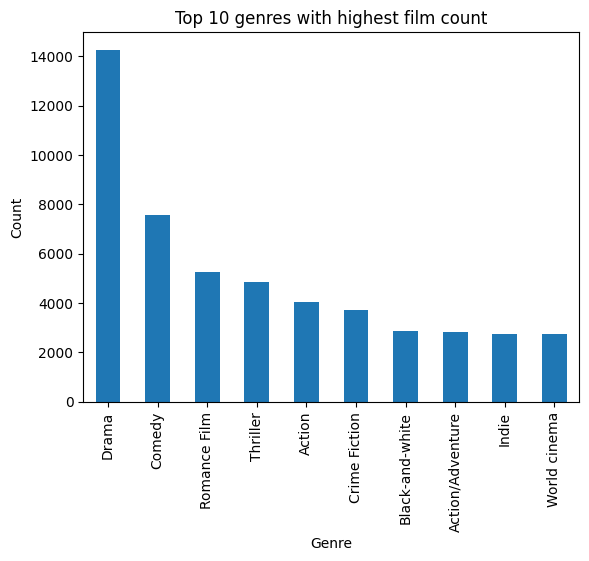

In [55]:
# Plot top 10 most represented genres
genre_counts = genre_counts.sort_values(ascending=False).head(10)
genre_counts.plot.bar()
plt.title("Top 10 genres with highest film count")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

*Observation:* Based on the graph, it is evident that drama movies are significantly more represented than other genres.

*Decision:* In light of this observation, we have decided to focus our analysis primarily on drama movies, considering their substantial representation in the dataset.

## 3.2 Dataframe 2: Actors

In [56]:
# Count the number of unique IMDb actor IDs in the 'actors' DataFrame.
unique_actors = len(actors['IMDb_actor_ID'].unique())

print('There are {} unique actors out of {} entries. A actor plays on average in {} films' .format(unique_actors, len(actors.index),len(actors.index)/unique_actors))

There are 29897 unique actors out of 82510 entries. A actor plays on average in 2.759808676455832 films


This shows that there is a good range of actors in our dataset (i.e we don't have a large amount of different actors).

In [57]:
# Display a random sample of 5 rows from the 'actors' DataFrame.
actors.sample(5)

,IMDb_ID,IMDb_actor_ID,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,awards,nominations
3637,tt0105573,nm0001185,3,14481268,There Goes the Neighborhood,1992,Hector Elizondo,0,0
77883,tt0033973,nm0417837,1,26347221,Ohm Krüger,1941,Emil Jannings,1,1
62713,tt0044965,nm0934290,1,21997257,Night Raiders,1952,Whip Wilson,0,0
67176,tt1594921,nm3793361,2,24061146,L.A. Zombie,2010,Rocco Giovanni,0,0
2057,tt0097490,nm0000515,2,2053385,Heart of Dixie,1989,Virginia Madsen,0,0


In [58]:
# Display descriptive statistics for selected columns in the 'actors' DataFrame:
# - 'Movie release date'
# - 'awards'
# - 'nominations'
actors[['Movie release date','awards','nominations']].describe()

,Movie release date,awards,nominations
count,82510.0,82510.000000,82510.000000
mean,1978.964889,0.048043,0.216180
std,25.196735,0.245123,0.811486
min,1930.0,0.000000,0.000000
25%,1957.0,0.000000,0.000000
50%,1985.0,0.000000,0.000000
75%,2002.0,0.000000,0.000000
max,2012.0,4.000000,17.000000


*Observation:* We can see that, on average, an actor has less than 0.05 Oscars, which may be an important factor if there is a correlation with the frequency of an actor's selection